<h1>Proyecto, Procesamiento de lenguaje natural aplicado al análisis de opinión política para las elecciones presidenciales en Colombia 2022<span class="tocSkip"></span></h1> 

>**Maestría en Analítica de Datos**  
>**Facultad de Ingeniería y Ciencias Básicas.**  
>**Universidad Central  2021 - III**  
>**Integrantes del trabajo:**  
>- Maria Alejandra Castillo Pabon
>- David Alejandro Ballesteros Díaz

# Librerias
Las librerías que se utilizan para la limpieza y transformación de los datos son:

In [1]:
#!pip install nltk
#!pip install wordcloud
import pandas as pd
import glob
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
from spacy.lang.es import STOP_WORDS

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\malej\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Funciones personalizadas
Se crean las funciones personalizadas para la limpieza y transformación de los datos:

## Consolidar dataframe
Función que permite consolidar todos los archivos que contienen tweets de un candidato específico.

In [2]:
def consolidar(ruta,clave):
    df=pd.DataFrame()
    lista=[file_name for file_name in glob.glob(ruta+'/'+'*.csv') if file_name.find(clave) > 0]
    for archivo in lista:
        df0= pd.read_csv(archivo,index_col=False)
        df=pd.concat([df0, df])
    return(df)

## Tranformar texto de miles
Función que permite reemplazar las letras que representan el "mil" por los ceros correspondientes.

In [3]:
def valor_k(x):
    x=str(x)
    if x.find(".")>0 or x.find(",")>0:
        x=int(re.sub('[.,k,K,\s,a-zA-Z]','',x))*100
    elif x =='nan':
        x=0
    elif x.find("K") >0 or x.find("mil") >0:
        x=int(re.sub('[k,K\s,a-zA-Z]','',x))*1000
    else:
        x= int(x)
    return(x)

## Limpiar carateres especiales
Función que permite realizar la limpieza del texto.

In [4]:
def mencion(texto):
    nuevo_texto =str(texto)
    if nuevo_texto is None:
        pass
    else:
        try:
            nuevo_texto = texto.lower()
        except:
            pass
        regex = '@[a-z0-9\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\-\\/\\:\\;\\<\\=\\>\\?\\\[\\\\\\]\\^_\\`\\{\\|\\}\\~\\¡\\¿]+'
        nuevo_texto=re.findall(regex, nuevo_texto)
        return(nuevo_texto)

In [12]:
def limpiar(texto):
    nuevo_texto =str(texto)
    if nuevo_texto is None:
        pass
    else:
        try:
            nuevo_texto = texto.lower()
        except:
            pass
        nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
        #regex = '@[a-z0-9\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\-\\/\\:\\;\\<\\=\\>\\?\\\[\\\\\\]\\^_\\`\\{\\|\\}\\~\\¡\\¿]+(\s)'
        regex = '@[a-z0-9\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\-\\/\\:\\;\\<\\=\\>\\?\\\[\\\\\\]\\^_\\`\\{\\|\\}\\~\\¡\\¿]+'
        nuevo_texto = re.sub(regex , ' ', nuevo_texto)
        regex = '[\\!\\"\\“\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\-\\/\\:\\;\\<\\=\\>\\?\\[\\\\\\]\\^_\\`\\{\\|\\}\\~\\¡\\¿\\.\\,\\·]'
        nuevo_texto = re.sub(regex , ' ', nuevo_texto)
        nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
        nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
        nuevo_texto=nuevo_texto.replace("replying to", "")
        nuevo_texto=nuevo_texto.replace("Replying to", "")
    return(nuevo_texto)

## Guardar Dataframe - CSV
Función que permite guardar el dataframe limpio en formato CSV.

In [6]:
def guardar_csv (df,nombre_archivo):
    df.to_csv(nombre_archivo+'.csv', index=False,encoding='utf-8')
    return('El archivo '+nombre_archivo+'.csv fue guardado exitosamente')

## Words Cloud
Función que permite generar una nube de las palabras que más se repiten en un texto determinado para posteriormente generar el gráfico "words cloud".

In [7]:
def lluvia(df,texto,lista):
    lista=lista
    stop_words = list(stopwords.words(['spanish','english']))
    stop_words.extend(("jul","agost","oct","jun","tweet","com","quote","cita","nov","aug","may","citar","q","ago","pm","Colombia","país","colombia","and",".",",","que"))
    stop_words.extend((lista))
    df=df.dropna()
    text = ' '.join(df) 
    wordcloud = WordCloud(width=1024, height=800, stopwords=stop_words, background_color="white", min_font_size=14).generate(text) 
    plt.figure(figsize= (8, 8), facecolor=None)
    plt.suptitle(texto,size=20) 
    plt.imshow(wordcloud)
    plt.axis('off') 
    plt.tight_layout(pad = 0) 
    return (plt.show())

Función que permite identificar el lema o raíz de de una palabra.

In [8]:
def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

# Limpieza y Consolidación

## Consolidación Entorno
Teniendo en cuenta que la extacción de los datos se generó más de un archivo con la información de un candidato, se hace necesario consolidar ésta información en un solo dataframe. Como resultado de éste proceso, se generarán 5 dataframe, uno por cada candidato (Óscar Ivan Zuliaga, María Fernanda Cabal, Rodolfo Hernandéz, Gustavo Petro y Sergio Fajardo) 

In [9]:
usuarios=("OIZuluaga","MariaFdaCabal","ingrodolfohdez","petrogustavo","sergio_fajardo")
ruta='C:\\Users\David\Python\PNL\Entorno'
df=pd.DataFrame()
for usuario in usuarios:
    df0=consolidar(ruta,usuario)
    df0['usuario']=usuario
    df=pd.concat([df0, df])
df=df.drop_duplicates(['id', 'nombre','usuario'], keep='last')
df0 = df['id'].value_counts()
df0=pd.DataFrame(df0, columns=['id','conteo']).reset_index()
df0.drop(columns="conteo", inplace=True)
df0=df0.rename(columns={"index": "id", "id": "conteo"})
df1 = df.merge(df0, left_on="id", right_on="id", how='left')
df2= pd.read_csv(ruta +"\clasificacion_usuarios.csv" ,index_col=False,encoding='latin')
df1= df1.merge(df2[["id","grupo"]], left_on="id", right_on="id", how='left')
guardar_csv(df1,"entorno_consolidado")

'El archivo entorno_consolidado.csv fue guardado exitosamente'

## Limpieza Tweets
Se realiza la limpieza del texto para cada uno de los dataframe generados en el paso anterior y posteriormente se generan 5 nuevos dataframe.

In [14]:
usuarios=("ingrodolfohdez","OIZuluaga","MariaFdaCabal","petrogustavo","sergio_fajardo")
ruta='C:\\Users\malej\Documents\GitHub\ProyectoGrado\datos\datos_sin_procesar\candidatotweet'
for usuario in usuarios:
    df=consolidar(ruta,usuario)
    df['cantidad_comentarios']=df['cantidad_comentarios'].apply(valor_k)
    df['cantidad_likes']=df['cantidad_likes'].apply(valor_k)
    df['Cantidad_Retweets']=df['Cantidad_Retweets'].apply(valor_k)
    df['mencion']=df['texto'].apply(mencion)
    df['texto']=df['texto'].apply(limpiar)
    locals()["df_tweets_consolidado_"+usuario] = df
    guardar_csv (df,"df_tweets_consolidado_"+usuario)
    

## Carga de Archivos

In [15]:
dfzuluaga= pd.read_csv('df_tweets_consolidado_OIZuluaga.csv')
dfpetro= pd.read_csv('df_tweets_consolidado_petrogustavo.csv')
dfsergio= pd.read_csv('df_tweets_consolidado_sergio_fajardo.csv')
dfcabal= pd.read_csv('df_tweets_consolidado_MariaFdaCabal.csv')
dfrodolfo= pd.read_csv('df_tweets_consolidado_ingrodolfohdez.csv')

## Nube de Palabras
Se crea una nube de palabras más utilizadas en los tweets generados por cada candidato. Se decide eliminar en cada nube el nombre del candidato objeto de análisis. 

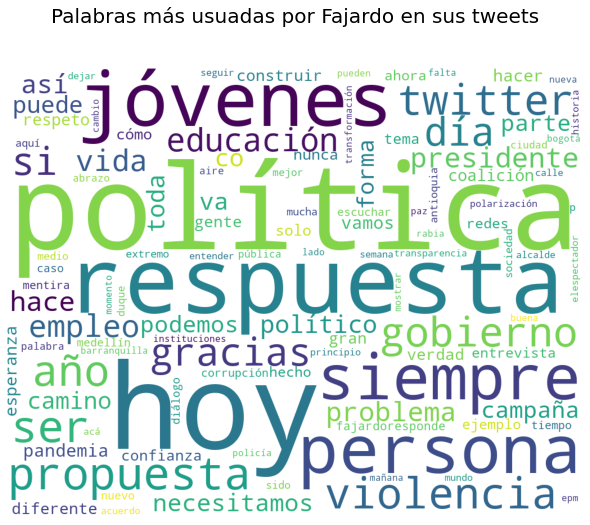

In [17]:
lista= ["sergio", "fajardo", "sergio fajardo","sergiofajardo"]
lluvia(dfsergio['texto'],'Palabras más usuadas por Fajardo en sus tweets',lista)

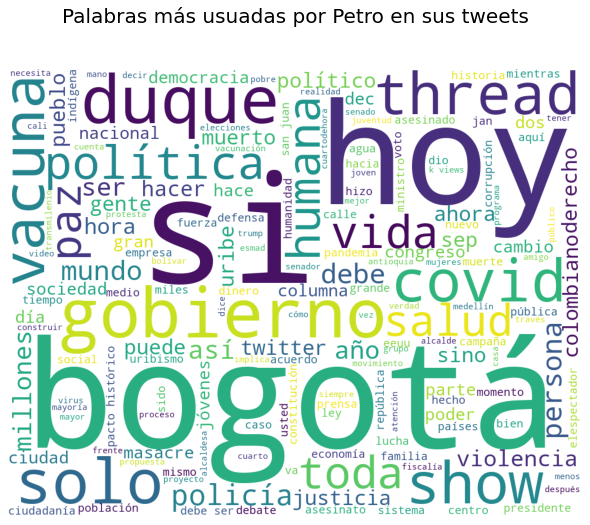

In [18]:
lista= ["petro","gustavo petro","gustavo"]
lluvia(dfpetro['texto'],'Palabras más usuadas por Petro en sus tweets',lista)

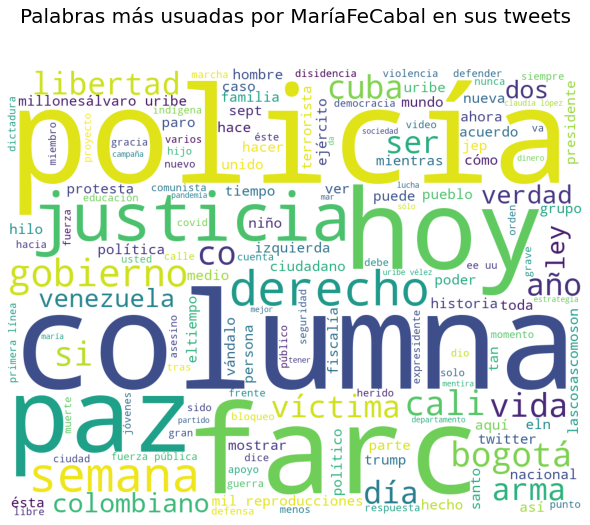

In [19]:
lista= ["cabal","maria fernanda","mariafernandacabal","maria","fernanda"]
lluvia(dfcabal['texto'],'Palabras más usuadas por MaríaFeCabal en sus tweets',lista)

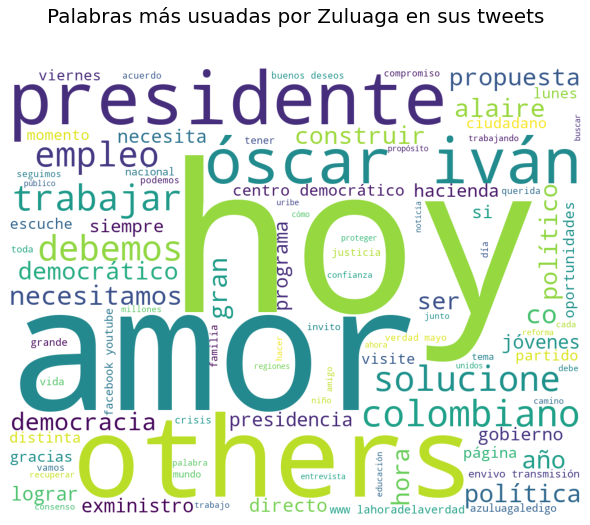

In [20]:
lista= ["zuluaga","iván zuluaga","óscar iván"]
lluvia(dfzuluaga['texto'],'Palabras más usuadas por Zuluaga en sus tweets',lista)

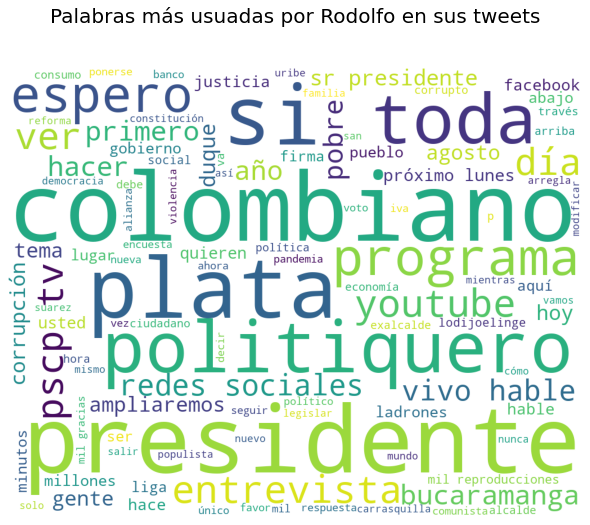

In [21]:
lista= ["ingrorodolfo","ingeniero","ing","rodolfo hernández", "rodolfo","hernández","hernandez","ingrodolfohdez","ingrodolfo"]
lluvia(dfrodolfo['texto'],'Palabras más usuadas por Rodolfo en sus tweets',lista)

# Análisis Exploratorio

Para el análisis explotario se realiza el cargue del modelo en español "es_core_news_md" de la librería de spacy, con el fin de poder tokenizar el texto y relizar un conteo de palabras e identificación de palabras más usados en los discursos de cada candidato.

In [22]:
nlp = spacy.load("es_core_news_md")

## Cargue de Dataframe

Se realiza el cargue de los dataframe que contienen los tweets escritos por los candidatos, los datos de estos dataframe ya han sido previamente limpiados. Adicionalmente, se eliminan los registros que contienen datos nulos ya que no aportan información relevante para el estudio. 

In [23]:
dfzuluaga= pd.read_csv('df_tweets_consolidado_OIZuluaga.csv')
dfzuluaga=dfzuluaga[dfzuluaga['nombre']== 'Óscar Iván Zuluaga']
dfzuluaga = dfzuluaga[dfzuluaga['texto'].notna()]
dfpetro= pd.read_csv('df_tweets_consolidado_petrogustavo.csv')
dfpetro = dfpetro[dfpetro['texto'].notna()]
dfsergio= pd.read_csv('df_tweets_consolidado_sergio_fajardo.csv')
dfsergio = dfsergio[dfsergio['texto'].notna()]
dfcabal= pd.read_csv('df_tweets_consolidado_MariaFdaCabal.csv')
dfcabal = dfcabal[dfcabal['texto'].notna()]
dfrodolfo= pd.read_csv('df_tweets_consolidado_ingrodolfohdez.csv')
dfrodolfo = dfrodolfo[dfrodolfo['texto'].notna()]

## Conteo de Tweets por cada candidato
print('Número de tweets Óscar Iván Zuluaga: ' + str(dfzuluaga.shape[0]))
print('Número de tweets Gustavo Petro: ' + str(dfpetro.shape[0]))
print('Número de tweets Sergio Fajardo: ' + str(dfsergio.shape[0]))
print('Número de tweets Maria Fernanda Cabal: ' + str(dfcabal.shape[0]))
print('Número de tweets Rodolfo Hernández: ' + str(dfrodolfo.shape[0]))

Número de tweets Óscar Iván Zuluaga: 407
Número de tweets Gustavo Petro: 2965
Número de tweets Sergio Fajardo: 612
Número de tweets Maria Fernanda Cabal: 1353
Número de tweets Rodolfo Hernández: 308


## Tokenización y Lematización de Texto

Se tokeniza el texto de los tweets generados por los candidatos, con el fin de dividir el texto en palabras, por otra parte se lematiza el texto para identificar la forma y lema de las palabra. Tanto el token como el lematizado, se guardan en variables independientes.

In [24]:
dfzuluaga['texto_tokenizado'] =dfzuluaga['texto'].apply(lambda x: nlp(x))
dfzuluaga['lematizado'] = dfzuluaga['texto'].apply(lambda x: lemmatizer(x))

dfpetro['texto_tokenizado'] =dfpetro['texto'].apply(lambda x: nlp(x))
dfpetro['lematizado'] = dfpetro['texto'].apply(lambda x: lemmatizer(x))

dfsergio['texto_tokenizado'] =dfsergio['texto'].apply(lambda x: nlp(x))
dfsergio['lematizado'] = dfsergio['texto'].apply(lambda x: lemmatizer(x))

dfcabal['texto_tokenizado'] =dfcabal['texto'].apply(lambda x: nlp(x))
dfcabal['lematizado'] = dfcabal['texto'].apply(lambda x: lemmatizer(x))

dfrodolfo['texto_tokenizado'] =dfrodolfo['texto'].apply(lambda x: nlp(x))
dfrodolfo['lematizado'] = dfrodolfo['texto'].apply(lambda x: lemmatizer(x))

## Nube de Palabras (texto lematizado)

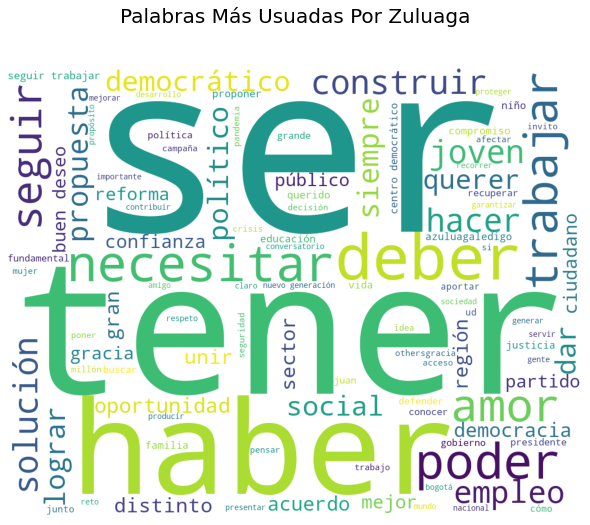

None


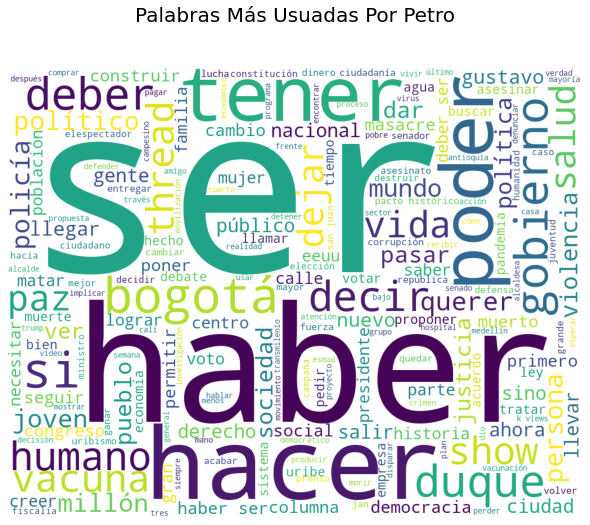

None


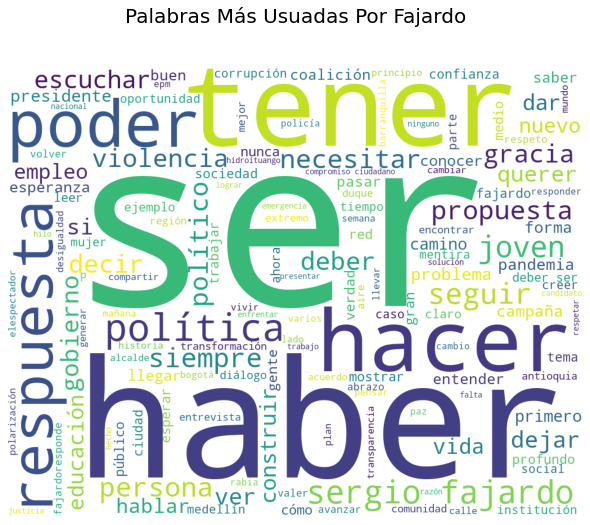

None


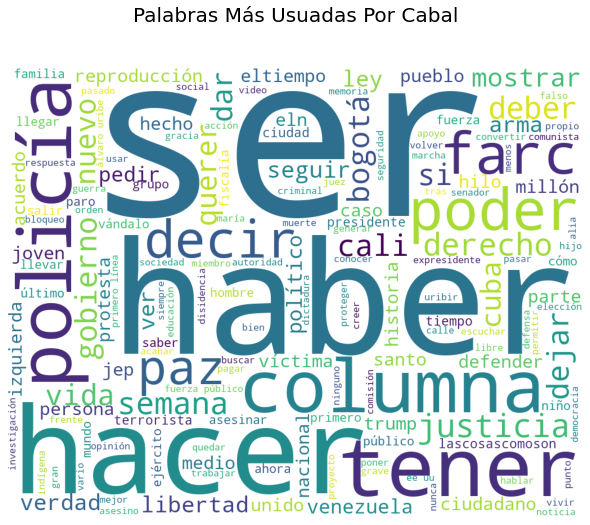

None


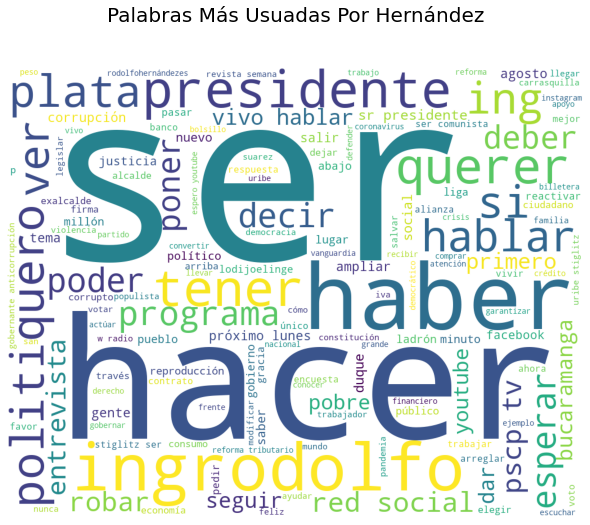

None


In [25]:
lista= ["hoy","others","twitter","sep","dec","vez","covid","petro","colombiano","colombia","señor","año","hora","mismo","ir","así","día","cada","dos","hacía","aquí","palabra","acá","algúno","sergio fajardo","fajardorespondir","fernanda cabal","solo","momento","mariafernandacabal","co","maria fernanda","fernanda cabal","fernanda","cabal","maria","mil","alguno","usted","sept","ingeniero","rodolfo hernández","mientras","tra","rodolfo hernández","rodolfo","hernández","hernandez"]
print(lluvia(dfzuluaga['lematizado'],'Palabras Más Usuadas Por Zuluaga',lista))
print(lluvia(dfpetro['lematizado'],'Palabras Más Usuadas Por Petro',lista))
print(lluvia(dfsergio['lematizado'],'Palabras Más Usuadas Por Fajardo',lista))
print(lluvia(dfcabal['lematizado'],'Palabras Más Usuadas Por Cabal',lista))
print(lluvia(dfrodolfo['lematizado'],'Palabras Más Usuadas Por Hernández',lista))

## Eliminación Stop Words

Se cargan las stop words en español que se encuentran definidas en la libreria de Spacy y se eliminan del texto tokenizado. Éstas palabras se eliminan ya que no aportan importancia en el análisis.  

In [55]:
tweetscandidatos = pd.concat([dfzuluaga, dfpetro, dfsergio,dfcabal,dfrodolfo]).reset_index(drop=True)

In [56]:
stopwords = nlp.Defaults.stop_words
nlp.Defaults.stop_words |= {"colombia","que","a",".",",","y","·","...","“","com","”"," ","","hoy","others","twitter","sep","dec","vez","covid","petro","colombiano","colombia","señor","año","hora","mismo","ir","así","día","cada","dos","hacía","aquí","palabra","acá","algúno","sergio fajardo","fajardorespondir","fernanda cabal","solo","momento","mariafernandacabal","co","maria fernanda","fernanda cabal","fernanda","cabal","maria","mil","alguno","usted","sept","ingeniero","rodolfo hernández","mientras","tra","rodolfo hernández","rodolfo","hernández","hernandez","q","tweet","quote","ingrodolfo","sergio","fajardo","and","jul"}
tweetscandidatos['token_stopword']=tweetscandidatos['texto_tokenizado'].apply(lambda x: [str(w) for w in x if not w.text in stopwords])
tweetscandidatos = tweetscandidatos.explode(column='token_stopword')

In [56]:
#guardar_csv (tweetscandidatos,"dfcandidatosconsolidado")
#tweetscandidatos= pd.read_csv('dfcandidatosconsolidado.csv')

'El archivo dfcandidatosconsolidado.csv fue guardado exitosamente'

## Palabras Más Usadas

In [52]:
print('--------------------------')
print('Palabras totales por candidato')
print('--------------------------')
tweetscandidatos.groupby(by='nombre')['token_stopword'].count()

--------------------------
Palabras totales por candidato
--------------------------


nombre
Gustavo Petro              74673
Ing Rodolfo Hernandez !     3368
María Fernanda Cabal       27576
Sergio Fajardo             10863
Óscar Iván Zuluaga          3680
Name: token_stopword, dtype: int64

## Palabras Distintas

In [53]:
print('----------------------------')
print('Palabras distintas por candidato')
print('----------------------------')
tweetscandidatos.groupby(by='nombre')['token_stopword'].nunique()

----------------------------
Palabras distintas por candidato
----------------------------


nombre
Gustavo Petro              17048
Ing Rodolfo Hernandez !     1642
María Fernanda Cabal        9128
Sergio Fajardo              4528
Óscar Iván Zuluaga          1778
Name: token_stopword, dtype: int64

In [57]:
tweetscandidatos.groupby(['nombre','token_stopword'])['token_stopword'] \
 .count() \
 .reset_index(name='count') \
 .groupby('nombre') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

nombre token_stopword  count
nombre                                                                      
Gustavo Petro           1942             Gustavo Petro         bogotá    429
                        7569             Gustavo Petro       gobierno    358
                        5462             Gustavo Petro          duque    352
                        11847            Gustavo Petro           país    271
                        8077             Gustavo Petro         humana    257
Ing Rodolfo Hernandez ! 18268  Ing Rodolfo Hernandez !     presidente     49
                        17789  Ing Rodolfo Hernandez !          hable     30
                        17323  Ing Rodolfo Hernandez !    colombianos     29
                        18214  Ing Rodolfo Hernandez !          plata     26
                        17656  Ing Rodolfo Hernandez !         espero     25
María Fernanda Cabal    20171     María Fernanda Cabal          citar    219
                        20276     María Fernanda Cabal        columna    152
                        27315     María Fernanda Cabal          uribe    112
                        22233     María Fernanda Cabal           farc    112
                        26525     María Fernanda Cabal         semana    108
Sergio Fajardo          31064           Sergio Fajardo       política     95
                        31525           Sergio Fajardo      respuesta     83
                        30930           Sergio Fajardo           país     82
                        30245           Sergio Fajardo        jóvenes     60
                        29807           Sergio Fajardo       gobierno     49
Óscar Iván Zuluaga      33578       Óscar Iván Zuluaga           país     72
                        32432       Óscar Iván Zuluaga           amor     35
                        33881       Óscar Iván Zuluaga       seguimos     29
                        32860       Óscar Iván Zuluaga    democrático     25
                        33926       Óscar Iván Zuluaga     soluciones     24

Text(0.5, 1.0, 'Número de Tokens por Tweet')

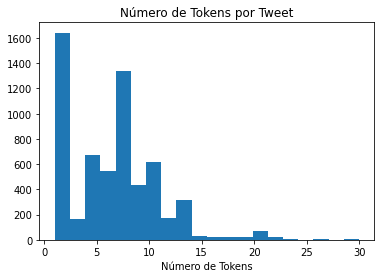

In [154]:
dfzuluaga ['num_tokens'] = [len (tokens) for tokens in dfzuluaga['sin_stopword']]
dfzuluaga['num_tokens']. hist ( grid = False , bins = 20 )
plt. xlabel ( 'Número de Tokens' )
plt. title ( 'Número de Tokens por Tweet' )